#This notebook shows calculation and plotting of mA/A for reads from different subsets of reads from each libary
#Libraries - CENP-A DiMeLo-seq, IgG control, Free pA-Hia5 control, untreated control
#subsets - reads with CENP-A-enriched-kmers, reads without CENP-A-enriched-kmers

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kde
%matplotlib inline

import math
import time

import pysam
from Bio import SeqIO

from scipy import sparse

from sklearn import cluster, datasets, mixture, decomposition
#Setup the plotting context
#sns.set(color_codes=True)
#sns.set_context("talk")
#sns.set_style("darkgrid")
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
##Guppy output merged into a single bam file
## Read ID | Flag | Ref | pos | MapQuality | Cigar | ref name of next read or mate | position of next read or mate | template length | sequence | quality score | Mm (modified base position skips) | Ml (modification confidence)

In [3]:
#%%bash
#source activate deepcrap
#samtools view /scratch/groups/astraigh/minion_seq/guppy_basecalling/DiMeLo_cen_enrich_trial1/bar17.2/bar17_guppy_merge.bam | head

In [2]:
def extract_Mm_Aa(Mm, Ml, thr):
    
       
    first=Mm.split(';')[0]
    if 'C+m' in first:
        A_n=len(Mm.split(';')[1].split(','))-1
        Mm_Aa = Mm.split(';')[1].split(',')[1:]
        Ml_Aa = np.array(Ml[0-A_n:],dtype=int)

    elif 'A+a' in first:
        A_n=len(Mm.split(';')[0].split(','))-1        
        Mm_Aa = Mm.split(';')[0].split(',')[1:]
        Ml_Aa=np.array(Ml[0:A_n],dtype=int)
    
    Mm_Aa_array = np.array(np.array(Mm_Aa), dtype=int)
    A_n_skips = np.sum(Mm_Aa_array)
    A_n_actual = A_n_skips + A_n
    
    frac_N_mods = {n:[] for n in thr}
    for perc in thr:
        thr256 = perc/100*256
        if A_n > 0:
            frac_N_mods[perc]=np.sum(Ml_Aa>=thr256)/A_n_actual
        else:
            frac_N_mods[perc]=0
    
    return Mm_Aa, Ml_Aa, frac_N_mods, A_n_actual

In [3]:
def parse_bam_Guppy_Nmods(filename_guppy, thr = [80,90,95]):
    outfilename = filename_guppy.replace('.bam','.An_Nmods.txt')
    with open(outfilename, "w") as f:
        N_mod_allthr_header = ''
        for i in thr:
            N_mod_allthr_header += 'frac_over_' + (str(i)) + '%'
            N_mod_allthr_header += '\t'
        outstring = 'Read_id' + '\t' + 'A_count' + '\t' + N_mod_allthr_header[0:-1] + '\n'
        f.write(outstring)

        reader = pysam.AlignmentFile(filename_guppy, check_sq=False)
        bamiter= reader.fetch(until_eof=True)
    
        while True:
            try:
                r=bamiter.__next__()
                Mm=(r.get_tag('Mm') if r.has_tag('Mm') else None)
                Ml=(r.get_tag('Ml') if r.has_tag('Ml') else None)
                readid=r.query_name
                #pos=r.reference_start
                #pos in bam is 1 indexed, python is 0 indexed
                #pos=pos-1
                #length=r.query_length
                #rev_strand=r.is_reverse

                if not Mm is None:
                    Mm_Aa, Ml_Aa, frac_N_mods, A_n  = extract_Mm_Aa(Mm, Ml, thr)
                    frac_N_mods_allthr_str = ''
                    for perc in thr:
                        frac_N_mods_allthr_str += str(frac_N_mods[perc])
                        frac_N_mods_allthr_str += '\t'
                    outstring = str(readid) + '\t' + str(A_n) + '\t' + frac_N_mods_allthr_str[0:-1] + '\n'
                    f.write(outstring)

            except StopIteration:
                reader.close()
                f.close()
                return

In [4]:
filename_guppy = {}
outfilename_guppy_MlAa = {}
for i in [17,18,19,20]:
    filename_guppy[i] = '/scratch/groups/astraigh/minion_seq/guppy_basecalling/DiMeLo_cen_enrich_trial1/bar'+str(i)+'.2/bar'+str(i)+'_guppy_merge.bam' 
    
    ##RUN this part only if the files don't exist already

    starttime = time.time()
    parse_bam_Guppy_Nmods(filename_guppy[i])
    print('Finished parsing barcode ' + str(i) + ' in ' + str(time.time()-starttime) + ' seconds')

Finished parsing barcode 17 in 47.830650091171265 seconds
Finished parsing barcode 18 in 43.83332324028015 seconds
Finished parsing barcode 19 in 42.03563356399536 seconds
Finished parsing barcode 20 in 40.496354818344116 seconds


In [5]:
filename_guppy_CA_enrich = {}
outfilename_guppy_MlAa_CA_enrich = {}
for i in [17,18,19,20]:
    filename_guppy_CA_enrich[i] = '/scratch/groups/astraigh/minion_seq/guppy_basecalling/DiMeLo_cen_enrich_trial1/bar'+str(i)+'.2/bar'+str(i)+'_guppy_merge.extract_CA.k21.ci100.bam'
    
    ##RUN this part only if the files don't exist already

    starttime = time.time()
    parse_bam_Guppy_Nmods(filename_guppy_CA_enrich[i])
    print('Finished parsing barcode ' + str(i) + ' in ' + str(time.time()-starttime) + ' seconds')

Finished parsing barcode 17 in 24.604758739471436 seconds
Finished parsing barcode 18 in 26.205589294433594 seconds
Finished parsing barcode 19 in 24.40490698814392 seconds
Finished parsing barcode 20 in 23.088953495025635 seconds


In [6]:
filename_guppy_rest = {}
for i in [17,18,19,20]:
    filename_guppy_rest[i] = '/scratch/groups/astraigh/minion_seq/guppy_basecalling/DiMeLo_cen_enrich_trial1/bar'+str(i)+'.2/bar'+str(i)+'_guppy_merge.NOTextract_CA.k21.ci100.bam'
    
    ##RUN this part only if the files don't exist already

    starttime = time.time()
    parse_bam_Guppy_Nmods(filename_guppy_rest[i])
    print('Finished parsing barcode ' + str(i) + ' in ' + str(time.time()-starttime) + ' seconds')

Finished parsing barcode 17 in 23.27612614631653 seconds
Finished parsing barcode 18 in 17.28199076652527 seconds
Finished parsing barcode 19 in 17.281346559524536 seconds
Finished parsing barcode 20 in 17.384405612945557 seconds


In [7]:
parsed_Nmods_df = {}
for i in [17,18,19,20]:
    parsed_Nmods_df[i] = pd.read_csv(filename_guppy[i].replace('.bam','.An_Nmods.txt'), sep='\t')

In [8]:
parsed_Nmods_df_CA_enrich = {}
for i in [17,18,19,20]:
    parsed_Nmods_df_CA_enrich[i] = pd.read_csv(filename_guppy_CA_enrich[i].replace('.bam','.An_Nmods.txt'), sep='\t')

In [9]:
parsed_Nmods_df_rest = {}
for i in [17,18,19,20]:
    parsed_Nmods_df_rest[i] = pd.read_csv(filename_guppy_rest[i].replace('.bam','.An_Nmods.txt'), sep='\t')

In [10]:
parsed_Nmods_df[17]

,Read_id,A_count,frac_over_10%,frac_over_80%,frac_over_90%,frac_over_95%
0,02f6cc44-d077-45ff-815f-afbc3d5801a7,1810,0.149171,0.000000,0.000000,0.000000
1,02f30dc0-03be-4fa6-8f56-1274cc0bf350,2061,0.524017,0.115963,0.046579,0.016497
2,02fb4266-e491-4e05-bd3e-ab098d4b59ef,474,0.016878,0.000000,0.000000,0.000000
3,0306c082-9006-4999-a42a-78a260ee7caf,0,0.000000,0.000000,0.000000,0.000000
4,02fadf9c-16ef-4881-bff3-81f4777062f0,68,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
230211,29548abd-38fd-4b3b-94f3-c5ee423bcc81,2889,0.042229,0.003808,0.001385,0.000000
230212,2950a028-3e8a-4992-9ba1-e6bab7e05458,2665,0.003002,0.000000,0.000000,0.000000
230213,29519436-c22f-42b8-a28e-79f45a017d53,2090,0.001435,0.000000,0.000000,0.000000
230214,295e90be-2e94-4f5c-9b4b-4c969a74182c,5666,0.002647,0.000176,0.000000,0.000000


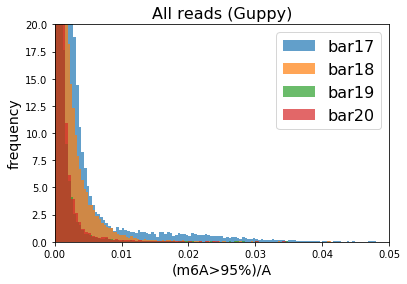

In [11]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df[i]['frac_over_95%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.05)
plt.xlabel('(m6A>95%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('All reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

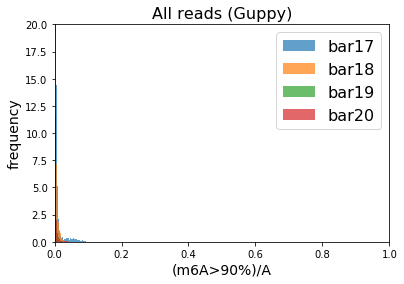

In [12]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df[i]['frac_over_90%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,1)
plt.xlabel('(m6A>90%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('All reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

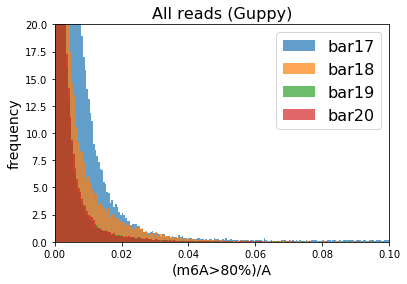

In [13]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df[i]['frac_over_80%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.1)
plt.xlabel('(m6A>80%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('All reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

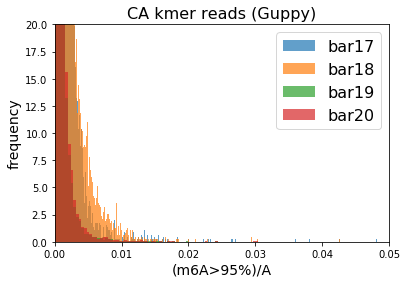

In [16]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df_CA_enrich[i]['frac_over_95%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.05)
plt.xlabel('(m6A>95%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('CA kmer reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

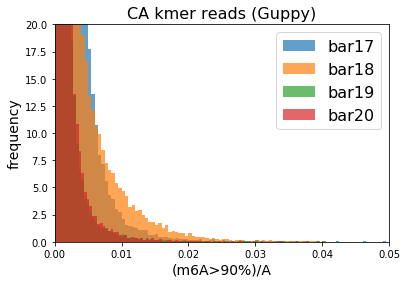

In [17]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df_CA_enrich[i]['frac_over_90%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.05)
plt.xlabel('(m6A>90%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('CA kmer reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

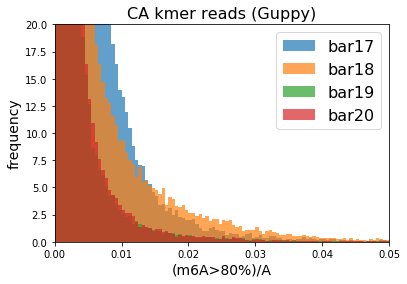

In [18]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df_CA_enrich[i]['frac_over_80%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.05)
plt.xlabel('(m6A>80%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('CA kmer reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

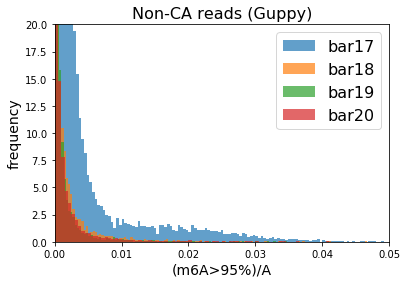

In [19]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df_rest[i]['frac_over_95%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.05)
plt.xlabel('(m6A>95%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('Non-CA reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

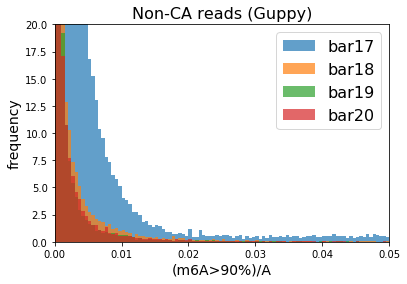

In [20]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df_rest[i]['frac_over_90%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.05)
plt.xlabel('(m6A>90%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('Non-CA reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

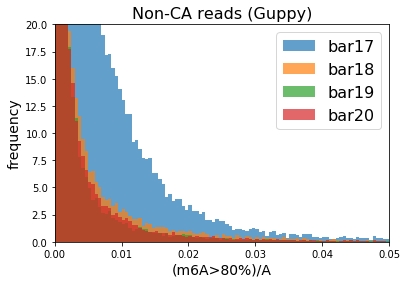

In [21]:
for i in [17,18,19,20]:
    plt.hist(parsed_Nmods_df_rest[i]['frac_over_80%'], density = True, bins=2000, alpha=0.7 , label = 'bar' + str(i))
plt.ylim(0,20)
plt.xlim(0,0.05)
plt.xlabel('(m6A>80%)/A', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)
plt.title('Non-CA reads (Guppy)', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [14]:
for i in [17,18,19,20]:
    parsed_Nmods_df[i]['Nmods_95'] = parsed_Nmods_df[i]['A_count']*parsed_Nmods_df[i]['frac_over_95%']
    parsed_Nmods_df[i]['Nmods_90'] = parsed_Nmods_df[i]['A_count']*parsed_Nmods_df[i]['frac_over_90%']
    parsed_Nmods_df[i]['Nmods_80'] = parsed_Nmods_df[i]['A_count']*parsed_Nmods_df[i]['frac_over_80%']
    

In [15]:
for i in [17,18,19,20]:
    parsed_Nmods_df_CA_enrich[i]['Nmods_95'] = parsed_Nmods_df_CA_enrich[i]['A_count']*parsed_Nmods_df_CA_enrich[i]['frac_over_95%']
    parsed_Nmods_df_CA_enrich[i]['Nmods_90'] = parsed_Nmods_df_CA_enrich[i]['A_count']*parsed_Nmods_df_CA_enrich[i]['frac_over_90%']
    parsed_Nmods_df_CA_enrich[i]['Nmods_80'] = parsed_Nmods_df_CA_enrich[i]['A_count']*parsed_Nmods_df_CA_enrich[i]['frac_over_80%']


In [16]:
for i in [17,18,19,20]:
    parsed_Nmods_df_rest[i]['Nmods_95'] = parsed_Nmods_df_rest[i]['A_count']*parsed_Nmods_df_rest[i]['frac_over_95%']
    parsed_Nmods_df_rest[i]['Nmods_90'] = parsed_Nmods_df_rest[i]['A_count']*parsed_Nmods_df_rest[i]['frac_over_90%']
    parsed_Nmods_df_rest[i]['Nmods_80'] = parsed_Nmods_df_rest[i]['A_count']*parsed_Nmods_df_rest[i]['frac_over_80%']
    

In [25]:
parsed_Nmods_df[17]

,Read_id,A_count,frac_over_80%,frac_over_90%,frac_over_95%,Nmods_95,Nmods_90,Nmods_80
0,02f6cc44-d077-45ff-815f-afbc3d5801a7,1810,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,02f30dc0-03be-4fa6-8f56-1274cc0bf350,2061,0.115963,0.046579,0.016497,34.0,96.0,239.0
2,02fb4266-e491-4e05-bd3e-ab098d4b59ef,474,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0306c082-9006-4999-a42a-78a260ee7caf,0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,02fadf9c-16ef-4881-bff3-81f4777062f0,68,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
230211,29548abd-38fd-4b3b-94f3-c5ee423bcc81,2889,0.003808,0.001385,0.000000,0.0,4.0,11.0
230212,2950a028-3e8a-4992-9ba1-e6bab7e05458,2665,0.000000,0.000000,0.000000,0.0,0.0,0.0
230213,29519436-c22f-42b8-a28e-79f45a017d53,2090,0.000000,0.000000,0.000000,0.0,0.0,0.0
230214,295e90be-2e94-4f5c-9b4b-4c969a74182c,5666,0.000176,0.000000,0.000000,0.0,0.0,1.0


In [17]:
total_perc_mod = {n:{} for n in [17,18,19,20]}
for i in [17,18,19,20]:
    for j in [80,90,95]:
        Nmods_perc = 'Nmods_' + str(j)
        total_perc_mod[i][j]=sum(parsed_Nmods_df[i][Nmods_perc])/sum(parsed_Nmods_df[i]['A_count'])*100

In [18]:
total_perc_mod_CA_enrich = {n:{} for n in [17,18,19,20]}
for i in [17,18,19,20]:
    for j in [80,90,95]:
        Nmods_perc = 'Nmods_' + str(j)
        total_perc_mod_CA_enrich[i][j]=sum(parsed_Nmods_df_CA_enrich[i][Nmods_perc])/sum(parsed_Nmods_df_CA_enrich[i]['A_count'])*100

In [19]:
total_perc_mod_rest = {n:{} for n in [17,18,19,20]}
for i in [17,18,19,20]:
    for j in [80,90,95]:
        Nmods_perc = 'Nmods_' + str(j)
        total_perc_mod_rest[i][j]=sum(parsed_Nmods_df_rest[i][Nmods_perc])/sum(parsed_Nmods_df_rest[i]['A_count'])*100

In [20]:
total_perc_mod_CA_overRest = {n:{} for n in [17,18,19,20]}
for i in [17,18,19,20]:
    for j in [80,90,95]:
        Nmods_perc = 'Nmods_' + str(j)
        total_perc_mod_CA_overRest[i][j]=total_perc_mod_CA_enrich[i][j]/total_perc_mod_rest[i][j]

In [21]:
display(pd.DataFrame.from_dict(total_perc_mod).T)
print('Total % m6A/A for all reads')

,80,90,95
17,0.448606,0.184959,0.072076
18,0.228695,0.093355,0.037991
19,0.091948,0.030206,0.011677
20,0.096434,0.031911,0.012424


Total % m6A/A for all reads


In [22]:
display(pd.DataFrame.from_dict(total_perc_mod_CA_enrich).T)
print('Total % m6A/A for CA kmer reads')

,80,90,95
17,0.329448,0.130287,0.052007
18,0.296521,0.124664,0.051195
19,0.105598,0.036401,0.014385
20,0.112577,0.039105,0.015494


Total % m6A/A for CA kmer reads


In [23]:
display(pd.DataFrame.from_dict(total_perc_mod_rest).T)
print('Total % m6A/A for non-CA reads')

,80,90,95
17,0.631670,0.269094,0.103681
18,0.069599,0.019915,0.007017
19,0.062647,0.016909,0.005864
20,0.061680,0.016423,0.005813


Total % m6A/A for non-CA reads


In [24]:
display(pd.DataFrame.from_dict(total_perc_mod_CA_overRest).T)
print('Fold Enrichment CA/non-CA of m6A/A')

,80,90,95
17,0.521551,0.484171,0.501602
18,4.260399,6.259801,7.296257
19,1.685609,2.152793,2.453193
20,1.825180,2.381149,2.665305


Fold Enrichment CA/non-CA of m6A/A
